In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json

import signature.signature.tensor_algebra as ta
from simulation.diffusion import Diffusion
from scipy.optimize import minimize

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

# plt.style.use('seaborn-v0_8-deep')

Text(0.5, 1.0, 'Driving Brownian motion W')

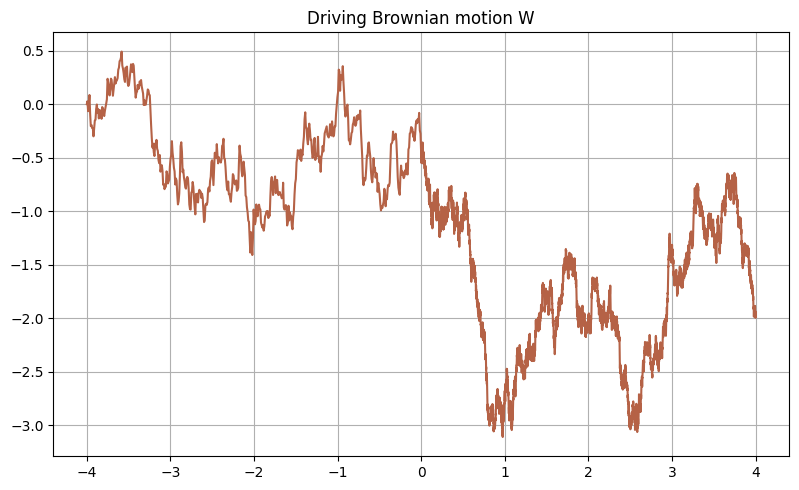

In [2]:
T = 4
t_grid = np.concatenate([np.linspace(-T, -0.0001, 500), np.linspace(0, T, T * 365 * 5 + 1)])

rng = np.random.default_rng(seed=42)

diffusion = Diffusion(t_grid=t_grid, rng=rng)
W = diffusion.brownian_motion().squeeze()

fig, ax = plt.subplots()

ax.plot(t_grid, W)
ax.set_title("Driving Brownian motion W")

In [3]:
N = 10

e = ta.AlgebraBasis(dim=2, trunc=N)

In [4]:
%%time

path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid[t_grid >= 0], W[t_grid >= 0]]).T

W_sig = ta.path_to_signature(path=path_pos, trunc=N)

CPU times: total: 156 ms
Wall time: 261 ms


In [44]:
%%time

lam = np.array([3, 3])
SigS = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

CPU times: total: 6.12 s
Wall time: 9.05 s


## OU representation

$$
d\sigma_t = \mu (\theta - \sigma_t) dt + dW_t
$$

In [45]:
mu = 5
theta = 0
nu = 1

ou = diffusion.ornstein_uhlenbeck(lam=mu, theta=theta, sigma=nu, squeeze=True)

Text(0.5, 1.0, 'OU trajectory')

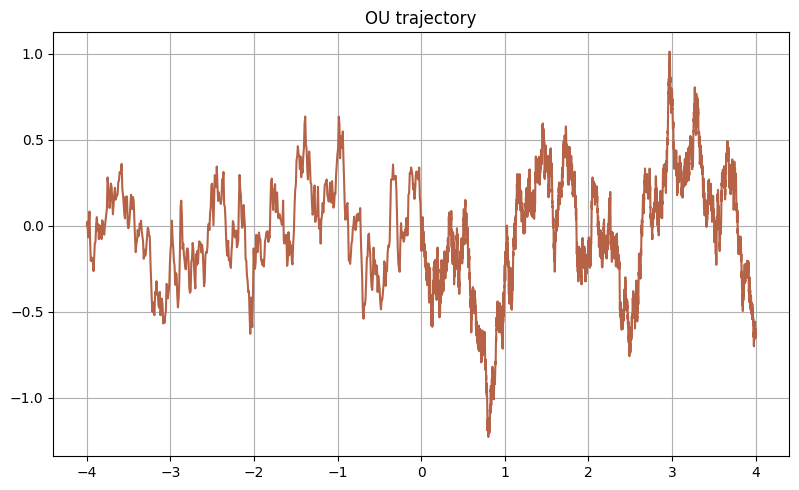

In [46]:
fig, ax = plt.subplots()
ax.plot(t_grid, ou)
ax.set_title("OU trajectory")

#### Representations via fixed-point Picard iterations

In [49]:
from typing import Callable

def repr_operator(ell, lam, mu: Callable, sigma: Callable, x0=0):
    return e[0] * x0 + ta.tensor_prod_word(ta.G(ell, lam) + mu(ell), 1) + ta.tensor_prod_word(sigma(ell), 2)

mu_ou = lambda ell: ell * (-mu)
sigma_ou = lambda ell: e[0] * 1

In [50]:
l_mu_iter = e[0] * 0
for i in range(N + 1):
    l_mu_iter = repr_operator(l_mu_iter, lam, mu_ou, sigma_ou)
print(l_mu_iter)

1.0*2 + -2.0*21 + -2.0*211 + -8.0*2111 + -56.0*21111 + -560.0*211111 + -7280.0*2111111 + -116480.0*21111111 + -2213120.0*211111111 + -48688640.0*2111111111


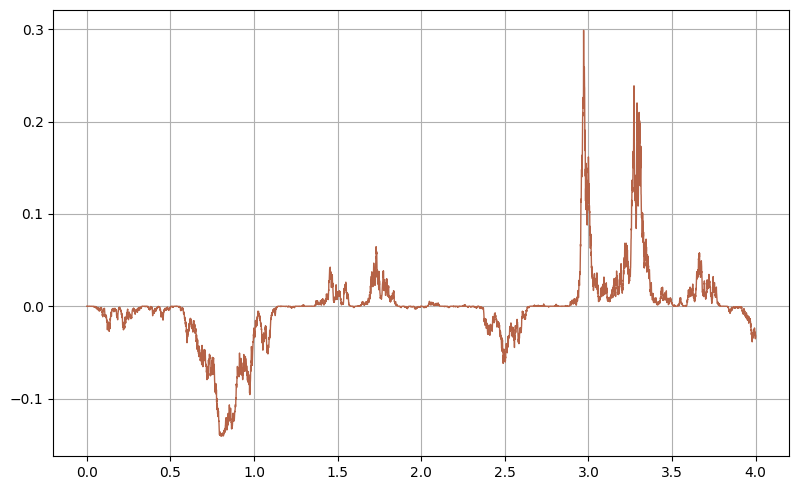

In [51]:
plt.plot(t_grid[t_grid >= 0], (SigS @ (e[2222] * 2 + e[222])), "-", lw=1.)

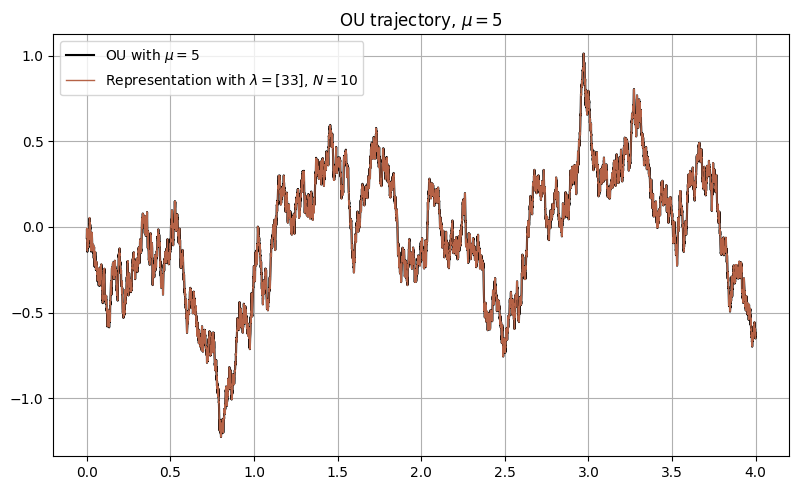

In [52]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

# ax.plot(t_grid[t_grid >= 0][idx_start:idx_start+step], (SigS @ (Ø * theta + _2)).real[idx_start:idx_start+step], "b", lw=1)
ax.plot(t_grid[t_grid >= 0], ou[t_grid >= 0], "k", lw=1.5, label=f"OU with $\mu={mu}$")
ax.plot(t_grid[t_grid >= 0], (SigS @ (e[0] * theta + l_mu_iter)).real, "-", label=f"Representation with $\lambda={lam}$, $N={N}$", lw=1.)
ax.set_title(f"OU trajectory, $\mu={mu}$")
ax.legend()

In [53]:
s0 = ou[t_grid >= 0][0]

In [55]:
l_mu_iter_lam0_dict = {}

for repr_trunc in range(2, 11):
    l_mu_iter_lam0 = e[0] * 0
    for i in range(repr_trunc + 1):
        l_mu_iter_lam0 = repr_operator(l_mu_iter_lam0, np.zeros(2), mu_ou, sigma_ou, x0=s0)
    l_mu_iter_lam0_dict[repr_trunc] = l_mu_iter_lam0

### Signature representation of OU

In [56]:
def y_min_max(process, eps=0.2):
    y_min = min(np.min(process) * (1 + eps), np.min(process) * (1 - eps))
    y_max = max(np.max(process) * (1 + eps), np.max(process) * (1 - eps))
    return y_min, y_max

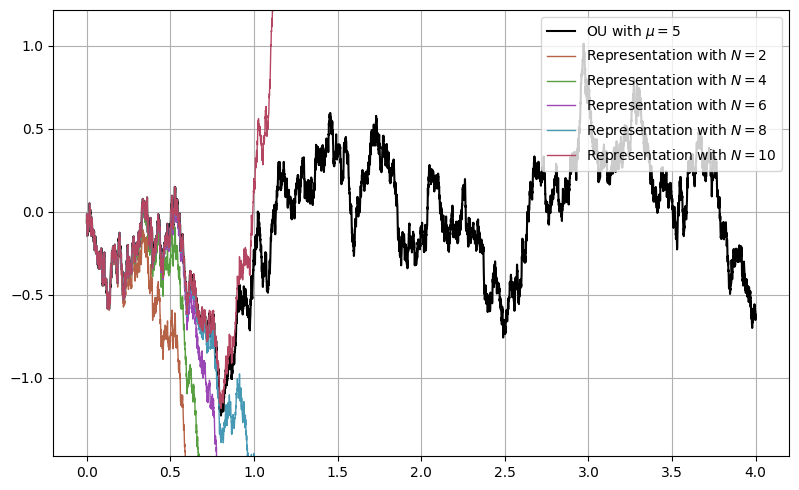

In [57]:
fig, ax = plt.subplots()


plt.plot(t_grid[t_grid >= 0], ou[t_grid >= 0], "k", label=f"OU with $\mu={mu}$")
for k in [2, 4, 6, 8, 10]:
    plt.plot(t_grid[t_grid >= 0], (W_sig @ l_mu_iter_lam0_dict[k]).real, "-", label=f"Representation with $N={k}$", lw=1)
plt.ylim(y_min_max(ou[t_grid >= 0]))
plt.legend(loc=1)

fig.savefig("ou_representation_convergence.pdf", format="pdf", transparent=True)

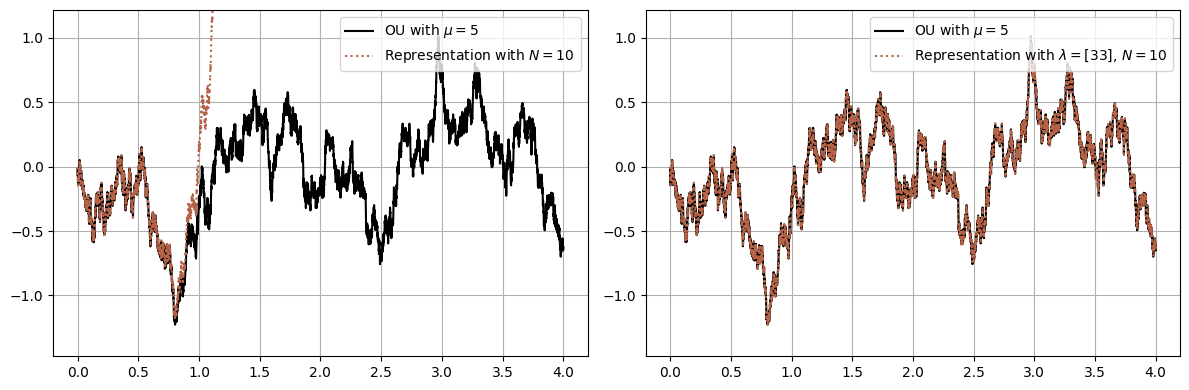

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

idx_start = 0
step = 500

ax[0].plot(t_grid[t_grid >= 0], ou[t_grid >= 0], "k", label=f"OU with $\mu={mu}$")
ax[0].plot(t_grid[t_grid >= 0], (W_sig @ l_mu_iter_lam0).real, ":", label=f"Representation with $N={N}$")
ax[0].set_ylim(y_min_max(ou[t_grid >= 0]))
ax[0].legend(loc=1)

ax[1].plot(t_grid[t_grid >= 0], ou[t_grid >= 0], "k", label=f"OU with $\mu={mu}$")
ax[1].plot(t_grid[t_grid >= 0], (SigS @ (e[0] * theta + l_mu_iter)).real, ":", label=f"Representation with $\lambda={lam}$, $N={N}$")
ax[1].set_ylim(y_min_max(ou[t_grid >= 0]))
ax[1].legend(loc=1)

fig.tight_layout()
fig.savefig("signature_ou_representation.pdf", format="pdf", transparent=True)

### Langevin dynamics

$$
dX_t = - \mu X_t^p dt + dW_t
$$

In [59]:
%%time
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=2)

CPU times: total: 12.6 s
Wall time: 25.4 s


In [61]:
%%time

N = 10
lam = 20 * np.ones(2)
SigS = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam)

CPU times: total: 21.8 s
Wall time: 33.1 s


In [62]:
mu = 100
p = 3

In [63]:
def simulate_langevin(t_grid, W, mu, p):
    X = np.zeros_like(W)
    X[0] = 0
    dt = np.diff(t_grid)
    dW = np.diff(W)
    for i in range(X.size - 1):
        X[i + 1] = X[i] - mu * (X[i]**p) * dt[i] + dW[i]
    return X

X = simulate_langevin(t_grid, W, mu, p)

In [64]:
mu_langevin = lambda l: ta.shuffle_pow(l, p, shuffle_table=shuffle_table) * (-mu)
sigma_langevin = lambda l: e[0] * 1

In [65]:
%%time

l_langevin_stat = e[0] * 0
for i in range(N + 1):
    l_langevin_stat = repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)

# print(l_langevin_stat)
print("Convergence: ", not bool(l_langevin_stat - repr_operator(l_langevin_stat, lam, mu_langevin, sigma_langevin)))

Convergence:  True
CPU times: total: 62.5 ms
Wall time: 173 ms


In [68]:
%%time

x0 = X[t_grid >= 0][0]
l_langevin = e[0] * 0
for i in range(N + 2):
    l_langevin = repr_operator(l_langevin, np.zeros(2), mu_langevin, sigma_langevin, x0=x0)

# print(l_langevin)
print("Convergence: ", not bool(l_langevin - repr_operator(l_langevin, lam, mu_langevin, sigma_langevin)))

Convergence:  False
CPU times: total: 0 ns
Wall time: 78 ms


StatSig RMSE:  0.07130526485395257


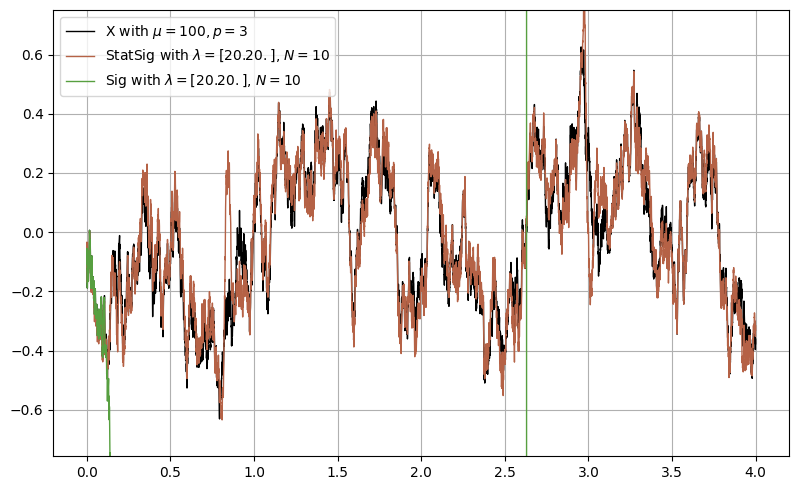

In [69]:
fig, ax = plt.subplots()
idx_start = 0
step = 500

ax.plot(t_grid[t_grid >= 0], X[t_grid >= 0], lw=1, color="k", ls="-", label=f"X with $\mu={mu}, p = {p}$")
ax.plot(t_grid[t_grid >= 0], (SigS @ l_langevin_stat), "-", lw=1, label=f"StatSig with $\lambda={lam}$, $N={N}$")
ax.plot(t_grid[t_grid >= 0], (W_sig @ l_langevin), "-", lw=1, label=f"Sig with $\lambda={lam}$, $N={N}$")
ax.set_ylim(y_min_max(X[t_grid >= 0]))
ax.legend()

print("StatSig RMSE: ", np.sqrt(np.mean(((SigS @ l_langevin_stat) - X[t_grid >= 0])**2)))

## Regressions

## Compute the signatures

In [127]:
N = 6
e = ta.AlgebraBasis(dim=2, trunc=N)

lam_1 = 5
lam_langevin_statsig = 2.4 # 2.4 # 5
lam_langevin_ou = 2.1 # 4.7 # 3.75

T = 4
t_grid = np.concatenate([np.linspace(-T, -0.0001, 500), np.linspace(0, T, T * 365 * 10 + 1)])
t_grid_pos = t_grid[t_grid >= 0]

In [128]:
mu = 5

rng = np.random.default_rng(seed=42)
diffusion = Diffusion(t_grid=t_grid, rng=rng)

W = diffusion.brownian_motion().squeeze()
ou_mu = diffusion.ornstein_uhlenbeck(lam=mu).squeeze()

path = np.vstack([t_grid, W]).T
path_pos = np.vstack([t_grid[t_grid >= 0], W[t_grid >= 0]]).T

### Signal $S_t = \dfrac{1}{\sqrt{1.01 + \sin(2 Z_t)}}$

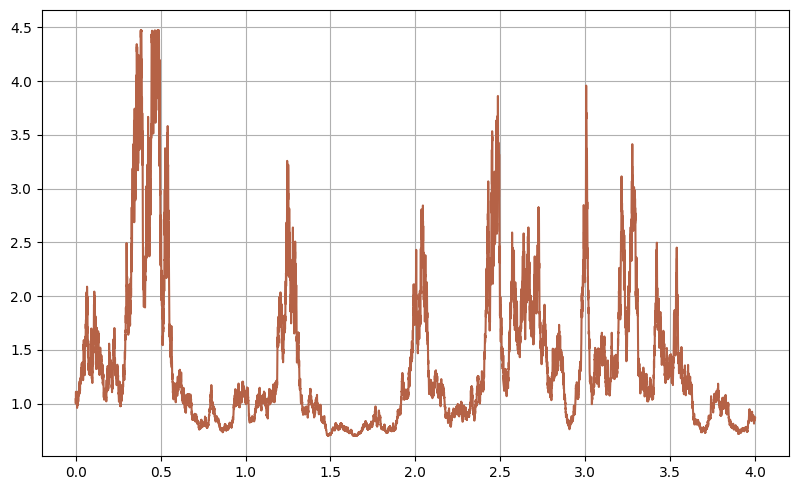

In [129]:
signal_1 = 1 / np.sqrt(1.05 + np.sin(2 * ou_mu[t_grid >= 0]))
plt.plot(t_grid_pos, signal_1)

## Langevin signal

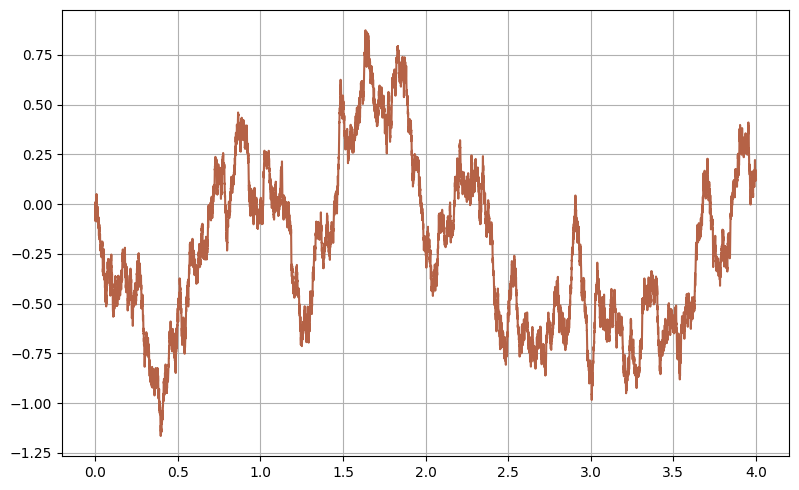

In [130]:
mu = 10
p = 5

langevin = simulate_langevin(t_grid, W, mu, p)

signal_2 = langevin[t_grid >= 0]
plt.plot(t_grid_pos, signal_2)

In [131]:
%%time

W_sig = ta.path_to_signature(path=path_pos, trunc=N)

CPU times: total: 31.2 ms
Wall time: 37.6 ms


In [132]:
%%time

ou_lam_1 = diffusion.ornstein_uhlenbeck(lam=lam_1).squeeze()
path_pos_ou_lam_1 = np.vstack([t_grid[t_grid >= 0], ou_lam_1[t_grid >= 0]]).T
OU_sig_1 = ta.path_to_signature(path=path_pos_ou_lam_1, trunc=N)

ou_lam_2 = diffusion.ornstein_uhlenbeck(lam=lam_langevin_ou).squeeze()
path_pos_ou_lam_2 = np.vstack([t_grid[t_grid >= 0], ou_lam_2[t_grid >= 0]]).T
OU_sig_2 = ta.path_to_signature(path=path_pos_ou_lam_2, trunc=N)

CPU times: total: 156 ms
Wall time: 300 ms


In [133]:
%%time

SigS_1 = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam_1)
SigS_2 = ta.path_to_fm_signature(path=path, trunc=N, t_grid=t_grid, lam=lam_langevin_statsig)

CPU times: total: 422 ms
Wall time: 822 ms


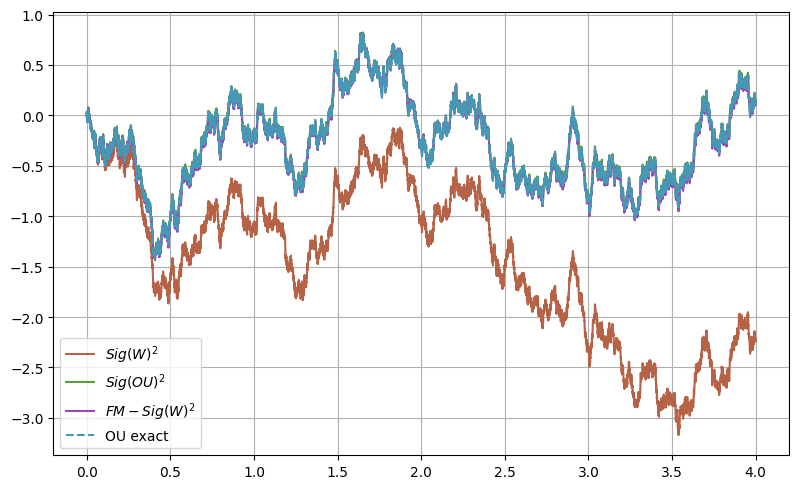

In [134]:
plt.plot(t_grid_pos, (W_sig @ e[2]), label=r"$Sig(W)^2$")
plt.plot(t_grid_pos, (OU_sig_2 @ e[2]), label=r"$Sig(OU)^2$")
plt.plot(t_grid_pos, (SigS_2 @ e[2]), label=r"$FM-Sig(W)^2$")
plt.plot(t_grid_pos, ou_lam_2[t_grid >= 0], "--", label=r"OU exact")
plt.legend()

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy.optimize import minimize

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


def learn_alpha(signal, X, trunc, idx_train):
    
    def loss(x):
        model = ElasticNet(alpha=x[0], l1_ratio=x[1])
        # model = Lasso(alpha=alpha[0])
        model.fit(X[:idx_train], signal[:idx_train])

        signal_pred = model.predict(X)
        rmse = root_mean_squared_error(signal, signal_pred)
        return rmse

    optim_res = minimize(loss, x0=[0.00001, 0.5], method="L-BFGS-B", bounds=[(0, 1), (0, 1)])
    return optim_res.x[0], optim_res.x[1]


def do_regression(signal, sigs, sig_labels, trunc, idx_train, idx_val, alphas=None, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(t_grid_pos, signal, "k", label='Signal', lw=1.5)

    if alphas is None:
        alphas = [None] * len(sigs)
    
    for alpha, label, sig in zip(alphas, sig_labels, sigs):
        X_test = sig.array[:ta.number_of_words_up_to_trunc(trunc, dim=2)].T
    
        scaler = StandardScaler()
        scaler.fit(X_test[:idx_val])

        X_test = scaler.transform(X_test)
        X_val = X_test[:idx_val]
        X_train = X_test[:idx_train]

        if alpha is None:
            alpha, l1_ratio = learn_alpha(signal[:idx_val], X_val, trunc, idx_train)
            print(f"Calibrated alpha for {label}: ", alpha, "l1 ratio:", l1_ratio)
        
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        # model = Lasso(alpha=alpha)
        model.fit(X_val, signal[:idx_val])

        signal_pred = model.predict(X_test)

        rmse = root_mean_squared_error(signal, signal_pred)
        print(f"RMSE ({label}): {rmse}")
        # Plot results
        ax.plot(t_grid_pos, signal_pred, "-", lw=1, label=label)
    
    ax.set_xlabel("$t$")
    # plt.ylabel("$Y_t$")
    
    eps = 0.2
    y_min = min(np.min(signal) * (1 + eps), np.min(signal) * (1 - eps))
    y_max = max(np.max(signal) * (1 + eps), np.max(signal) * (1 - eps))
    
    ax.set_ylim([y_min, y_max])
    ax.vlines(t_grid_pos[idx_train], y_min, y_max, color="k", ls="--")
    ax.vlines(t_grid_pos[idx_val], y_min, y_max, color="k")
    ax.legend()
    plt.show()

In [137]:
trunc = 6
idx_train = 365 * 10
idx_val = 365 * 10 * 2

Calibrated alpha for Sig(W):  1.0494000521330017e-05 l1 ratio: 0.6330170402966797
RMSE (Sig(W)): 68.54538057001555
Calibrated alpha for Sig(OU):  0.01497093916573766 l1 ratio: 0.5222003189570567
RMSE (Sig(OU)): 0.2236499577724532
Calibrated alpha for FM-Sig(W):  0.02408508193574367 l1 ratio: 0.6021681456186381
RMSE (FM-Sig(W)): 0.1770777242693544


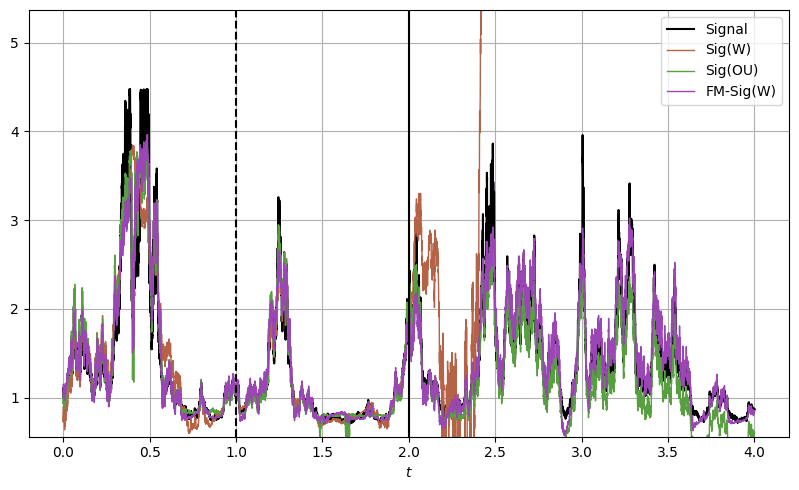

In [138]:
do_regression(signal=signal_1, sigs=[W_sig, OU_sig_1, SigS_1], sig_labels=["Sig(W)", "Sig(OU)", "FM-Sig(W)"], trunc=trunc, 
              idx_train=idx_train, idx_val=idx_val) # alphas=[0.001, 0.009, 0]

Calibrated alpha for Sig(W):  0.002165846009776261 l1 ratio: 0.5010832130680605
RMSE (Sig(W)): 1.8417012394155337
Calibrated alpha for Sig(OU):  0.0012263817097068767 l1 ratio: 0.5005771038202146
RMSE (Sig(OU)): 1.1025090793399903
Calibrated alpha for FM-Sig(W):  0.00032915358032049896 l1 ratio: 0.4999947133023322
RMSE (FM-Sig(W)): 0.09887147121169501


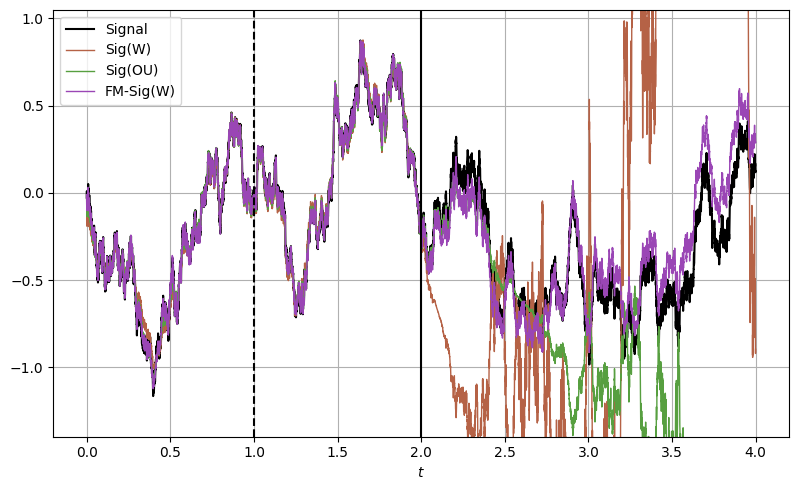

In [139]:
fig, ax = plt.subplots()

do_regression(signal=signal_2, sigs=[W_sig, OU_sig_2, SigS_2], sig_labels=["Sig(W)", "Sig(OU)", "FM-Sig(W)"], trunc=trunc, 
              idx_train=idx_train, idx_val=idx_val, ax=ax) # alphas=[0.001, 0.009, 0]

fig.tight_layout()
fig.savefig("regression_comparison.pdf", format="pdf", transparent=True)

#### Learning $\lambda$ for OU signature

In [117]:
def grid_search_lambda_sig_ou(signal, t_grid, trunc, diffusion, idx_train, idx_val, lam_arr = None):
    
    def loss_lam(lam):
        ou_lam = diffusion.ornstein_uhlenbeck(lam=lam).squeeze()
        path_pos_ou_lam = np.vstack([t_grid[t_grid >= 0], ou_lam[t_grid >= 0]]).T
        path_pos_ou_lam = path_pos_ou_lam[:idx_val]
        OU_sig = ta.path_to_signature(path=path_pos_ou_lam, trunc=trunc)

        X = OU_sig.array.T
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        alpha, l1_ratio = learn_alpha(signal, X=X, trunc=trunc, idx_train=idx_train)
        
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        # model = Lasso(alpha=alpha)
        model.fit(X[:idx_train], signal[:idx_train])
        
        rmse = root_mean_squared_error(model.predict(X), signal)
        print(f"lambda = {lam}, alpha = {alpha}, l1_ratio = {l1_ratio}, rmse = {rmse}")

        return rmse
    
    if lam_arr is None:
        lam_arr = np.arange(0.2, 20.1, 0.2)
    rmse_array = [loss_lam(lam) for lam in lam_arr]
    lam_opt = lam_arr[np.argmin(rmse_array)]
    print("optimal_lambda =", lam_opt)
    plt.plot(lam_arr, rmse_array)
    
    # optim_res = minimize(loss_lam, x0=0.1, method="powell", bounds=[(0.1, 15)])
    # print(optim_res)
    return lam_opt, rmse_array

In [122]:
def grid_search_lambda_stat_sig(signal, t_grid, trunc, diffusion, idx_train, idx_val, lam_arr = None):
    
    W = diffusion.brownian_motion().squeeze()
    path = np.vstack([t_grid, W]).T

    def loss_lam(lam):
        SigS = ta.path_to_fm_signature(path=path, trunc=trunc, t_grid=t_grid, lam=lam * np.ones(2))

        X = SigS.array.T[:idx_val]
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        alpha, l1_ratio = learn_alpha(signal, X=X, trunc=trunc, idx_train=idx_train)
        
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        # model = Lasso(alpha=alpha)
        model.fit(X[:idx_train], signal[:idx_train])
        
        rmse = root_mean_squared_error(model.predict(X), signal)
        print(f"lambda = {lam}, alpha = {alpha}, l1_ratio = {l1_ratio}, rmse = {rmse}")

        return rmse
    
    if lam_arr is None:
        lam_arr = np.arange(0.2, 20.1, 0.2)
    rmse_array = [loss_lam(lam) for lam in lam_arr]
    lam_opt = lam_arr[np.argmin(rmse_array)]
    print("optimal_lambda =", lam_opt)
    plt.plot(lam_arr, rmse_array)
    
    # optim_res = minimize(loss_lam, x0=0.1, method="powell", bounds=[(0.1, 15)])
    # print(optim_res)
    return lam_opt, rmse_array

lambda = 0.2, alpha = 1e-05, rmse = 10.600262222736832
lambda = 0.30000000000000004, alpha = 1e-05, rmse = 12.93851063211578
lambda = 0.4000000000000001, alpha = 1e-05, rmse = 14.175266365023155
lambda = 0.5000000000000001, alpha = 1e-05, rmse = 13.915410341271844
lambda = 0.6000000000000001, alpha = 1e-05, rmse = 12.742880622200301
lambda = 0.7000000000000002, alpha = 1e-05, rmse = 10.439260151738237
lambda = 0.8000000000000003, alpha = 1e-05, rmse = 7.932848386200705
lambda = 0.9000000000000001, alpha = 0.0032407766415640587, rmse = 0.3394168585139951
lambda = 1.0000000000000002, alpha = 0.003109317228352122, rmse = 0.5048987687147186
lambda = 1.1000000000000003, alpha = 0.0019850598293367806, rmse = 0.7923291518167556
lambda = 1.2000000000000004, alpha = 0.0036005239623367155, rmse = 0.3617367545715682
lambda = 1.3000000000000003, alpha = 0.0039005993595209176, rmse = 0.3281556538335715
lambda = 1.4000000000000004, alpha = 0.004248941429240073, rmse = 0.3343134110422907
lambda = 1.5

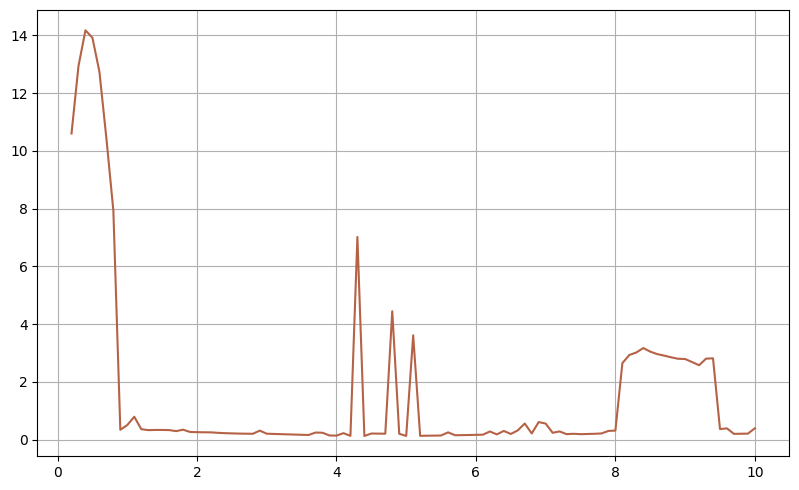

In [92]:
%%time

signal_val = signal_1[:idx_val]
lam_opt_1, lam_arr_1 = grid_search_lambda_sig_ou(signal_val, t_grid, trunc=trunc, diffusion=diffusion, idx_train=idx_train, idx_val=idx_val, lam_arr=np.arange(0.2, 10.1, 0.1))

lambda = 0.2, alpha = 0.09038726391483402, rmse = 0.33878168579145373
lambda = 0.4, alpha = 1e-05, rmse = 2.3712307469163476
lambda = 0.6000000000000001, alpha = 0.016279460148812406, rmse = 0.25453652055583204
lambda = 0.8, alpha = 0.08326063786359994, rmse = 0.43558437423546725
lambda = 1.0, alpha = 0.024962435157787233, rmse = 0.28461312379100845
lambda = 1.2, alpha = 0.027990354906839432, rmse = 0.2654022793767001
lambda = 1.4000000000000001, alpha = 0.028226624778661398, rmse = 0.26246881926800086
lambda = 1.6, alpha = 0.024875114820059187, rmse = 0.2579378595133026
lambda = 1.8, alpha = 0.02553570848093317, rmse = 0.25059756310722764
lambda = 2.0, alpha = 0.023479398624545334, rmse = 0.24519472389844954
lambda = 2.2, alpha = 0.029132227974831844, rmse = 0.23956215922126817
lambda = 2.4000000000000004, alpha = 0.019264780784623698, rmse = 0.20810031504501292
lambda = 2.6000000000000005, alpha = 0.0410172807904414, rmse = 0.23270370306480967
lambda = 2.8000000000000003, alpha = 0.0

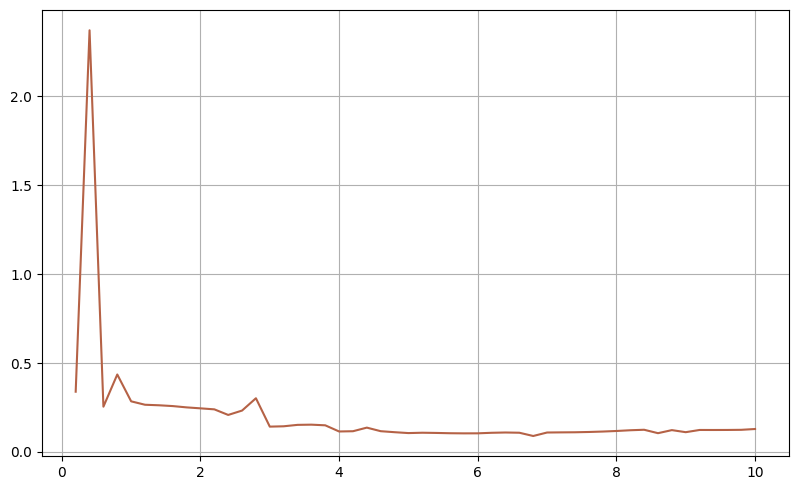

In [93]:
%%time

signal_val = signal_1[:idx_val]
lam_opt_1_statsig, lam_arr_1_statsig = grid_search_lambda_stat_sig(signal_val, t_grid, trunc=trunc, diffusion=diffusion, idx_train=idx_train, idx_val=idx_val, lam_arr=np.arange(0.2, 10.1, 0.2))

In [119]:
%%time
signal_val = signal_2[:idx_val]
lam_opt_2, lam_arr_2 = grid_search_lambda_sig_ou(signal_val, t_grid, trunc=trunc, diffusion=diffusion, idx_train=idx_train, idx_val=idx_val, lam_arr=np.arange(0.2, 10.1, 0.1))

lambda = 0.2, alpha = 0.004099979866978065, l1_ratio = 0.5020450114315536, rmse = 0.27985147275802336
lambda = 0.30000000000000004, alpha = 0.03879127542468556, l1_ratio = 0.8306952370265348, rmse = 0.16682211609844555
lambda = 0.4000000000000001, alpha = 0.031345186444039455, l1_ratio = 1.0, rmse = 0.15900534712340897
lambda = 0.5000000000000001, alpha = 0.029905167667885407, l1_ratio = 0.9734439596837896, rmse = 0.15298012361811406
lambda = 0.6000000000000001, alpha = 0.028416537138886616, l1_ratio = 1.0, rmse = 0.14766155858364796
lambda = 0.7000000000000002, alpha = 0.027741739561840527, l1_ratio = 1.0, rmse = 0.14304852026109016
lambda = 0.8000000000000003, alpha = 0.027384205091079396, l1_ratio = 1.0, rmse = 0.13884115930290492
lambda = 0.9000000000000001, alpha = 0.0012566983768627171, l1_ratio = 0.49997162815579044, rmse = 0.10141524675518084
lambda = 1.0000000000000002, alpha = 0.0007876789866658988, l1_ratio = 0.49998527761298966, rmse = 0.08013631728907124
lambda = 1.1000000

KeyboardInterrupt: 

lambda = 0.2, alpha = 0.0622116946288563, l1_ratio = 0.7764706097192117, rmse = 0.19570709146451287
lambda = 0.4, alpha = 0.062317799794935465, l1_ratio = 0.7767521565775188, rmse = 0.19579485666979296
lambda = 0.6000000000000001, alpha = 0.062133486989777074, l1_ratio = 0.7769647615620212, rmse = 0.19588017128579882
lambda = 0.8, alpha = 0.06219371950814076, l1_ratio = 0.7768433721606762, rmse = 0.1959664796428665
lambda = 1.0, alpha = 0.005042656329446207, l1_ratio = 0.7150440131859065, rmse = 0.08640693771577573
lambda = 1.2, alpha = 0.002909095745765253, l1_ratio = 0.6857699360775742, rmse = 0.0813735479488427
lambda = 1.4000000000000001, alpha = 0.002675927543978499, l1_ratio = 1.0, rmse = 0.07948768913789077
lambda = 1.6, alpha = 0.0029298667120433294, l1_ratio = 0.6730515457213491, rmse = 0.08061621363553073
lambda = 1.8, alpha = 0.004603269011045729, l1_ratio = 0.5002364157201734, rmse = 0.0891845208309954
lambda = 2.0, alpha = 0.00030052050807360015, l1_ratio = 0.4999908321433

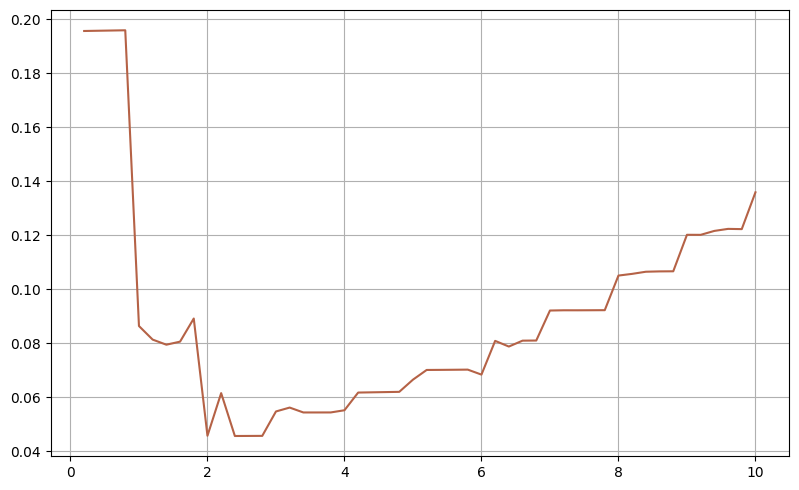

In [123]:
%%time
signal_val = signal_2[:idx_val]
lam_opt_2_statsig, lam_arr_2_statsig = grid_search_lambda_stat_sig(signal_val, t_grid, trunc=trunc, diffusion=diffusion, idx_train=idx_train, idx_val=idx_val, lam_arr=np.arange(0.2, 10.1, 0.2))